In [1]:
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
pd.reset_option('display.max_rows')

In [4]:
def extract_months_weeks_days(df) :#-> pd.DataFrame:
    # Extract month and week of the year and day of the week
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Day'] = df.index.dayofweek
    return df

def mean_daily_return_by_week(df):
    df['Daily Return'] = df['Adj. Close'].pct_change()
    weekly_mean_return = df.groupby('Week')['Daily Return'].mean().reset_index()
    return weekly_mean_return

def log_mean_daily_return_by_week(df):
    df['Daily Return'] = np.log(df['Adj. Close']/df['Adj. Close'].shift(1))
    log_weekly_mean_return = df.groupby('Week')['Daily Return'].mean().reset_index()
    return log_weekly_mean_return

def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    global log_ret
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [5]:
# Download and get Daily Returns
head = 'course/09-Python-Finance-Fundamentals/'
aapl = pd.read_csv(head + 'AAPL_CLOSE',index_col='Date',parse_dates=['Date'])
cisco = pd.read_csv(head + 'CISCO_CLOSE',index_col='Date',parse_dates=['Date'])
ibm = pd.read_csv(head + 'IBM_CLOSE',index_col='Date',parse_dates=['Date'])
amzn = pd.read_csv(head + 'AMZN_CLOSE',index_col='Date',parse_dates=['Date'])

In [7]:



df = pd.read_csv('course/09-Python-Finance-Fundamentals/AAPL_CLOSE', parse_dates=['Date'])

# Extract week of the year and day of the week
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.dayofweek

# Group by week and day, then sort by day
#weekly_df = df.groupby(['Week', 'Day']).apply(lambda x: x.sort_values('Date')).reset_index(drop=True)

# Display the weekly data
#weekly_df.head(100)

In [8]:
df.head(100)

,Date,Adj. Close,Week,Day
0,2012-01-03,53.063218,1,1
1,2012-01-04,53.348386,1,2
2,2012-01-05,53.940658,1,3
3,2012-01-06,54.504543,1,4
4,2012-01-09,54.418089,2,0
...,...,...,...,...
95,2012-05-18,68.437783,20,4
96,2012-05-21,72.424976,21,0
97,2012-05-22,71.868834,21,1
98,2012-05-23,73.622424,21,2


In [9]:
stocks = pd.concat([aapl['Adj. Close'],cisco['Adj. Close'],ibm['Adj. Close'],amzn['Adj. Close']],axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']
mean_daily_ret = stocks.pct_change(1).mean()
mean_daily_ret
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [10]:
mean_daily_ret

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [11]:
# Add weeks and days of week to the stocks
aapl = extract_months_weeks_days(aapl)
cisco = extract_months_weeks_days(cisco)
ibm = extract_months_weeks_days(ibm)
amzn = extract_months_weeks_days(amzn)

In [12]:
aapl.head(30)

,Adj. Close,Month,Week,Day
Date,,,,
2012-01-03,53.063218,1,1,1
2012-01-04,53.348386,1,1,2
2012-01-05,53.940658,1,1,3
2012-01-06,54.504543,1,1,4
2012-01-09,54.418089,1,2,0
2012-01-10,54.612933,1,2,1
2012-01-11,54.523898,1,2,2
2012-01-12,54.374217,1,2,3
2012-01-13,54.170341,1,2,4


In [13]:
# Get the mean daily return by week for each stock and concatenate them
df = log_mean_daily_return_by_week(aapl)
df = pd.concat([df,log_mean_daily_return_by_week(cisco)['Daily Return']],axis=1)
df = pd.concat([df,log_mean_daily_return_by_week(ibm)['Daily Return']],axis=1)
df = pd.concat([df,log_mean_daily_return_by_week(amzn)['Daily Return']],axis=1)

# Rename columns
df.columns = ['Week','aapl','cisco','ibm','amzn']
log_weekly_mean_return = df

In [14]:
df

,Week,aapl,cisco,ibm,amzn
0,1,-0.004910,-0.001693,-0.001827,-0.001909
1,2,-0.000318,-0.000784,-0.001744,-0.003509
2,3,-0.001576,0.003411,-0.000265,0.004869
3,4,-0.001507,0.000041,0.000759,0.004143
4,5,-0.000874,-0.004315,0.000570,-0.008660
5,6,0.007376,0.006611,-0.001118,0.001905
6,7,0.004973,0.005826,0.006476,0.002433
7,8,0.000565,-0.001436,0.001427,-0.000257
8,9,0.002056,-0.001046,0.002380,0.002860
9,10,-0.000442,0.002579,0.002791,0.003048


In [16]:
# Example usage
df = pd.read_csv('course/09-Python-Finance-Fundamentals/AAPL_CLOSE', index_col='Date', parse_dates=['Date'])
df = extract_months_weeks_days(df)
weekly_mean_return = mean_daily_return_by_week(df)
weekly_mean_return.head()

,Week,Daily Return
0,1,-0.004697
1,2,-0.000208
2,3,-0.001350
3,4,-0.000820
4,5,-0.000567


<Axes: xlabel='Date'>

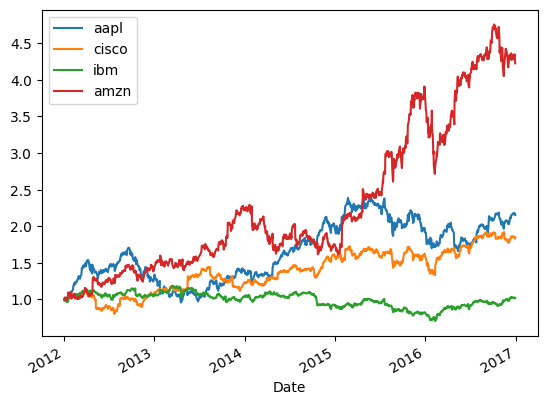

In [17]:
stock_normed = stocks/stocks.iloc[1]
stock_normed.plot()

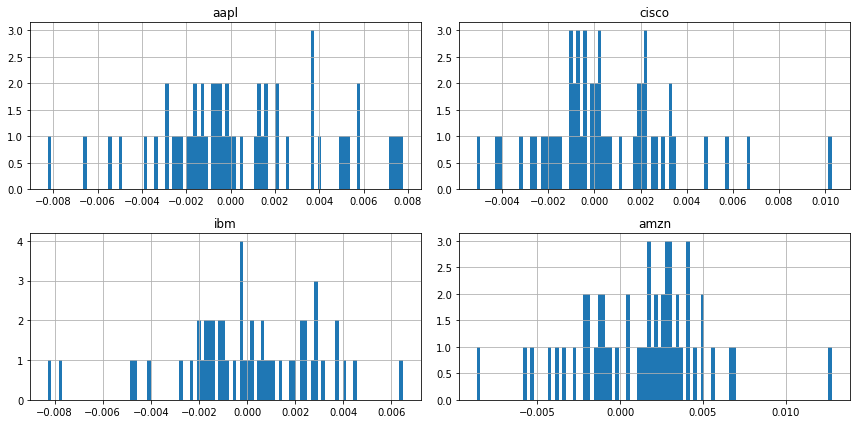

In [342]:
log_weekly_mean_return[['aapl','cisco','ibm','amzn']].hist(bins=100,figsize=(12,6));
plt.tight_layout()

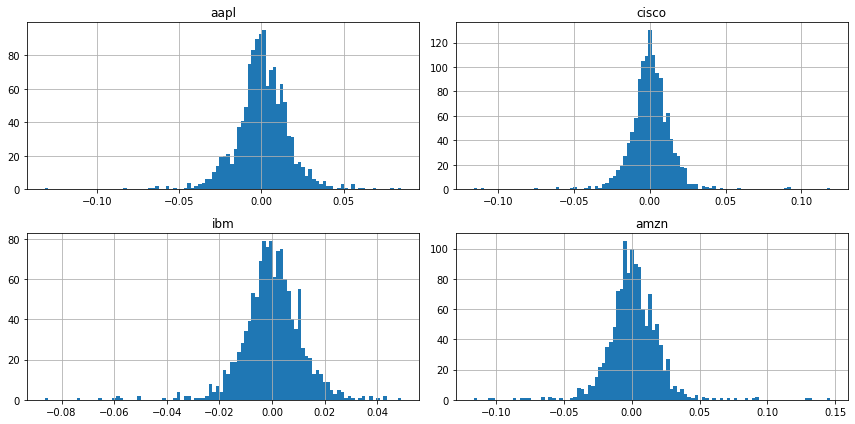

In [343]:
log_ret_all = np.log(stocks/stocks.shift(1))
log_ret_all.head()
log_ret_all.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [344]:
log_ret_all = extract_months_weeks_days(log_ret_all)
log_ret_all = log_ret_all[['Week','aapl','cisco','ibm','amzn']]

In [345]:
log_ret_all=log_ret_all.set_index('Week')

In [350]:
log_ret.head(20)

,aapl,cisco,ibm,amzn
Week,,,,
50,-0.006451,0.023260,0.003484,-0.021948
50,0.021597,-0.000505,0.008169,0.011716
50,-0.004421,-0.002531,-0.006457,0.004259
50,-0.017424,0.000507,-0.004988,-0.002028
50,-0.038285,0.006061,-0.001199,-0.008233
50,0.011381,-0.002824,-0.001183,-0.005338
50,-0.001555,-0.000471,-0.001918,0.007481
50,-0.007436,-0.015681,-0.010899,-0.014520
50,-0.001462,-0.017879,-0.010500,-0.002463


In [347]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [348]:
sharpe_arr.max()
sharpe_arr.argmax()
all_weights[1419,:]
max_sr_ret = ret_arr[1419]
max_sr_vol = vol_arr[1419]


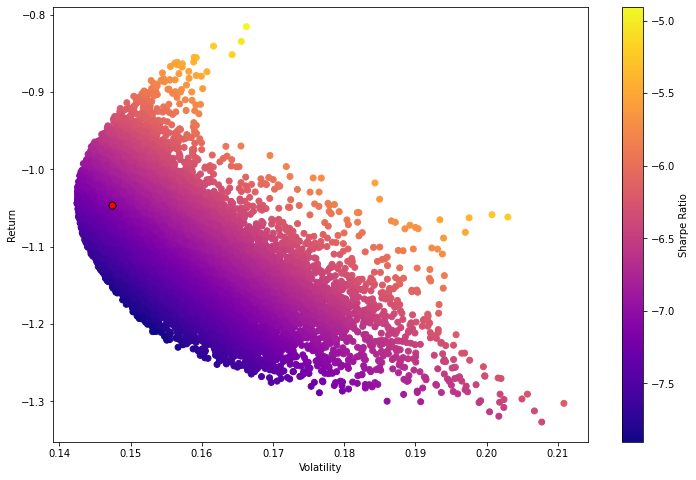

In [349]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [327]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

log_ret = log_ret_all.copy()



In [328]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)


In [295]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0307168703349947
       x: [ 2.663e-01  2.042e-01  1.340e-16  5.295e-01]
     nit: 7
     jac: [ 5.643e-05  4.184e-05  3.399e-01 -4.451e-05]
    nfev: 35
    njev: 7

In [336]:
max_week = max(log_ret.index)
opt_results_all = []
for ind in range(1, max_week):
    log_ret = log_ret_all.loc[ind].copy()
    opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    opt_results.x = opt_results.x.round(3)
    opt_results_all.append(opt_results)
 

In [332]:
type(opt_results_all)

list

In [337]:
for opt_results in opt_results_all:
    print(opt_results.x)

[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0.    0.472 0.    0.528]
[0.    0.04  0.404 0.556]
[0. 0. 1. 0.]
[0.71 0.29 0.   0.  ]
[0.332 0.074 0.594 0.   ]
[0. 0. 1. 0.]
[0.136 0.    0.633 0.231]
[0.    0.148 0.568 0.285]
[1. 0. 0. 0.]
[0.484 0.    0.336 0.18 ]
[0.    0.389 0.611 0.   ]
[1. 0. 0. 0.]
[0.    0.012 0.761 0.227]
[0. 1. 0. 0.]
[0.123 0.    0.725 0.152]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0.    0.128 0.    0.872]
[0.289 0.247 0.    0.464]
[0. 1. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[0.601 0.    0.    0.399]
[0.    0.853 0.    0.147]
[0.    0.276 0.158 0.566]
[0.635 0.    0.    0.365]
[0.924 0.076 0.    0.   ]
[0. 1. 0. 0.]
[0.497 0.    0.    0.503]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
[0.237 0.    0.763 0.   ]
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0.756 0.    0.244 0.   ]
[0. 0. 0. 1.]
[0.965 0.    0.    0.035]
[0. 0. 0. 1.]
[0.    0.586 0.414 0.   ]
[0. 0. 0. 1.]
[0.    0.524 0.051 0.424]
[0.468 0.    0.    0.532]
[0.    0.211 0.789 0.   ]
[0. 0. 0. 1.]


In [338]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [339]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [306]:
frontier_volatility = []
max_week = max(log_ret.index)
opt_results_all = []
for ind in range(1, max_week):
        log_ret = log_ret_all.loc[ind].copy()

        for possible_return in frontier_y:
                # function for return
                cons = ({'type':'eq','fun': check_sum},
                        {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})

                result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

                frontier_volatility.append(result['fun'])

In [309]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.18734979070484883
       x: [ 4.532e-01  2.552e-01  1.687e-01  1.230e-01]
     nit: 9
     jac: [ 2.181e-01  1.611e-01  1.668e-01  1.566e-01]
    nfev: 45
    njev: 9

In [308]:
frontier_volatility

[np.float64(0.23279311540469966),
 np.float64(0.2327931154049469),
 np.float64(0.23279311540479986),
 np.float64(0.2327931154047464),
 np.float64(0.23279311540487319),
 np.float64(0.2327931154047594),
 np.float64(0.23279311540475986),
 np.float64(0.2327931154047457),
 np.float64(0.23279311540473777),
 np.float64(0.2327931154047357),
 np.float64(0.23279311540470005),
 np.float64(0.2327931154047658),
 np.float64(0.2327931154047656),
 np.float64(0.2327931154047116),
 np.float64(0.23279311540479988),
 np.float64(0.23279311540470887),
 np.float64(0.23279311540469855),
 np.float64(0.23279311540469882),
 np.float64(0.23279311540469905),
 np.float64(0.23279311540473685),
 np.float64(0.2327931154047108),
 np.float64(0.23279311540472308),
 np.float64(0.23279311540470496),
 np.float64(0.232793115404985),
 np.float64(0.23279311540468675),
 np.float64(0.23279311540468603),
 np.float64(0.2327931154046921),
 np.float64(0.2327931154047469),
 np.float64(0.23279311540470868),
 np.float64(0.2327931154047

ValueError: x and y must have same first dimension, but have shapes (5100,) and (100,)

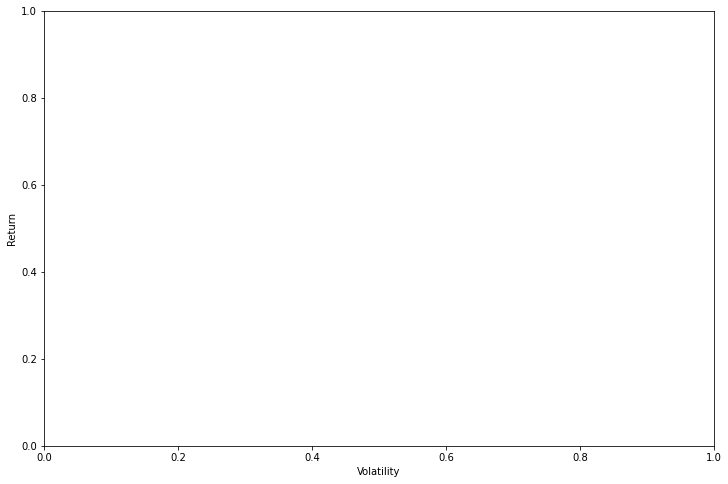

In [307]:
plt.figure(figsize=(12,8))
#plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
#plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)